# Optimism in Structured Bandits notebook 

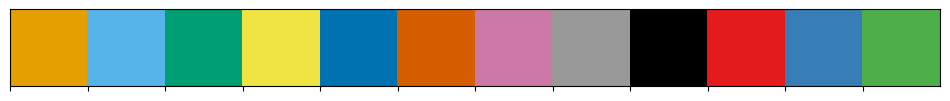

In [8]:
# IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import gym
from gym import spaces
import numpy as np
from Stochastic.src.environment.tree import Tree
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
colors = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]
sns.palplot(colors)
colors = sns.color_palette("hls", 12)

## Environment

In [18]:
class NestedBanditEnv(gym.Env):
    """
    Nested Bandit environment where each arm is a full path from root to leaf in a tree.
    The reward is the sum of sampled node values along the path.
    """

    def __init__(self, seed=None):
        super(NestedBanditEnv, self).__init__()
        self.tree = self.generate_tree()
        means = [self.tree.get_mu_leaf(leaf) for leaf in self.tree.get_all_leaves()]
        self.DELTA = np.array([max(means) - mean for mean in means])
        self.rng = np.random.default_rng(seed)

        self.tree.step()  # initial sampling
        self.leaves = self.tree.get_all_leaves()
        self.K = len(self.leaves)
        self.best_arm = np.argmax([value[2] for value in self.tree.get_mu_leaves()])

        self.action_space = spaces.Discrete(self.K)
        self.observation_space = spaces.Discrete(1)  # stateless

        self.reset()

    def generate_tree(self):
        tree = Tree() 
        root = tree.insert(parent_node=None, name="Targeting", mean=0, var=0)

        # First Layer
        #families, _ = tree.insert(parent_node=root, name="families", mean=0.35, var=0.1)
        #professionals, _ = tree.insert(parent_node=root, name="professionals", mean=0.45, var=0.1)
        families, _ = tree.insert(parent_node=root, name="families", mean=0.25, var=0.1)
        professionals, _ = tree.insert(parent_node=root, name="professionals", mean=0.25, var=0.1)

        # Second Layer
        #adults, _ = tree.insert(parent_node=families, name="adults", mean=0.05, var=0.1)
        adults, _ = tree.insert(parent_node=families, name="adults", mean=0.15, var=0.1)
        youngs, _ = tree.insert(parent_node=families, name="youngs", mean=0.08, var=0.1)

        start_up, _ = tree.insert(parent_node=professionals, name="start-up", mean=0.07, var=0.1)
        companies, _ = tree.insert(parent_node=professionals, name="companies", mean=0.15, var=0.1)

        # Third Layer
        radio, _ = tree.insert(parent_node=adults, name="radio", mean=0.3, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="tv", mean=0.02, var=0.1)
        magazines, _ = tree.insert(parent_node=adults, name="magazines", mean=0.01, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="supermarket", mean=0.3, var=0.1)

        youtube, _ = tree.insert(parent_node=youngs, name="youtube", mean=0.01, var=0.1)
        social_networks, _ = tree.insert(parent_node=youngs, name="social networks", mean=0.02, var=0.1)

        webinaire, _ = tree.insert(parent_node=start_up, name="webinaire", mean=0.3, var=0.1)
        events, _ = tree.insert(parent_node=start_up, name="events", mean=0.5, var=0.1)

        linkedin, _ = tree.insert(parent_node=companies, name="linkedin", mean=0.05, var=0.1)
        email, _ = tree.insert(parent_node=companies, name="email", mean=0.25, var=0.1)

        tree.step()
        return tree

    def reset(self):
        self.t = 0
        self.tree.step()  

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action index"
        self.t += 1

        selected_leaf = self.leaves[action]
        reward = self.tree.get_reward_leaf(selected_leaf)
        expected_reward = self.tree.get_mu_leaf(selected_leaf)

        best_arm_path = self.tree.find_best_arm_path()
        best_expected_reward = np.sum([node.mean for node in best_arm_path])
        best_leaf = best_arm_path[-1].name

        done = False
        info = {
            "step": self.t,
            "selected_leaf": selected_leaf.name,
            "expected_reward": expected_reward,
            "optimal": best_leaf,
            "path": best_arm_path,
            "best_expected_reward": best_expected_reward
        }
        self.tree.step()
        return 0, reward, done, info

    def render(self, mode="human"):
        self.tree.visualize_tree_mu()

## Experiment functions

In [10]:
def experiment(environment, agents, Nmc, T):
    all_data = {}
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)
        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    for episode in tqdm(range(Nmc)):
        environment.reset()
        agent.reset()   
        
        for t in range(T):
            if agent.nested():
                index_action = agent.draw_action(environment.tree)
            else:
                if agent.name()=="Exp3++":
                    index_action = agent.draw_action(gaps=environment.DELTA)
                else:
                    index_action = agent.draw_action()
            _, r, _, info = environment.step(index_action)
            agent.observe_reward(r)

            # Compute pseudo-regret: 
            data[episode, t] = info["best_expected_reward"] - info["expected_reward"] 
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None, horizon=5_000):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="stochastic bound")

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()



def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None, horizon=5_000):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    
    regrets : dict {'agent_name': np.array of regret}
    agents  : list of agent instances, each must have .action_history (flat list of actions played)
    """

    fig, axes = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        ax_regret.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        ax_regret.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="bound")

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time steps")
    ax_regret.legend()
    ax_regret.set_title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")

    # --- Histogram plot ---
    width = 0.8 / len(agents)  # Adjust width for overlap

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue  # Skip if no action data

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents)/2) * width + width/2
        ax_hist.bar(x, freqs, width=width, color=colors[i], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best arm = {env.best_arm})")
    ax_hist.legend()

    plt.tight_layout()
    if save_pdf:
        plt.savefig(save_pdf)
    plt.show()

## Agent : UCB

In [11]:
class UCB:
  def __init__(self, tree, T):
        self.tree = tree
        self.T = T
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.reset()     

  def reset(self, seed=None):
      self.rng = np.random.default_rng(seed)
      self.total_reward = 0
      self.t = 0  
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.action_history = []
  
  def draw_action(self):
    if self.t < self.K:
        action = self.t % self.K
    else:
        with np.errstate(divide='ignore', invalid='ignore'):
                empirical_means = np.divide(self.count_rewards, self.count_actions, out=np.zeros_like(self.count_rewards), where=self.count_actions != 0)
                ucbs = np.sqrt(2 * np.log(self.t) / self.count_actions)
                scores = empirical_means + ucbs
                action = np.argmax(scores)

    self.t += 1
    self.count_actions[action] += 1
    self.chosen_action = action
    self.action_history.append(action)
    return action

  def observe_reward(self, reward):
    self.total_reward += reward
    self.count_rewards[self.chosen_action] += reward

  def name(self):
    return 'UCB' 
  
  def nested(self):
      return False

## Agent : KL-UCB

In [12]:
class KLUCB():
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.c = 3
        self.T = T
        self.reset()     

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.total_reward = 0
        self.t = 0  
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.action_history = []

    @staticmethod
    def kl_divergence(p, q):
        eps = 1e-12  # avoid log(0)
        p = np.clip(p, eps, 1 - eps)
        q = np.clip(q, eps, 1 - eps)
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
    
    def find_upper_confidence_bound(self, ratio, N_a, t, tol=1e-6):
        """ higher q s.t N_a * d(p, q) <= log(t) + c * log(log(t)) """
        bound = np.log(t) + self.c * np.log(np.log(max(t, 2)))  # avoid log(0)
        low = ratio
        high = 1.0
        while high - low > tol:
            mid = (low + high) / 2
            if N_a * self.kl_divergence(ratio, mid) <= bound:
                low = mid
            else:
                high = mid
        return low    
    
    def draw_action(self):
        if self.t < self.K:
            chosen_action = self.t 
            self.t += 1
        else:
            t = self.t
            quantities = []
            for a in range(self.K):
                ratio_a = self.count_rewards[a] / np.maximum(self.count_actions[a], 1e-8)
                quantities.append(self.find_upper_confidence_bound(ratio_a, self.count_actions[a], self.t))
            chosen_action = np.argmax(quantities)
            self.t += 1

        self.count_actions[chosen_action] += 1
        self.action_history.append(chosen_action)
        self.chosen_action = chosen_action
        return chosen_action


    def observe_reward(self, reward):
        self.total_reward += reward
        self.count_rewards[self.chosen_action] += reward

    def name(self):
        return 'KL-UCB' 
    
    def nested(self):
        return False

## Nested Agent : NUCB

In [13]:
class NUCB:
  def __init__(self, tree, T):
    self.tree = tree
    self.T = T
    self.tree_structure = self.tree.extract_tree_structure_from_tree()
    self.L = len(self.tree_structure)
    leaves = self.tree.get_all_leaves()
    self.paths = [self.tree.get_parent_nodes(leaf) for leaf in leaves]
    self.len_paths = len(self.paths)
    self.all_nodes = tree.get_all_nodes()
    self.leaves_set = self.tree.get_all_leaves()
    self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
    self.leaves_name = [n.name for n in self.leaves_set]
    self.K = len(self.leaves_set)
    self.reset()     

  def reset(self, seed=None):
    self.rng = np.random.default_rng(seed) 
    self.total_reward = 0
    self.t = 0  
    self.counts = {node.name: float(0) for node in self.all_nodes}
    self.rewards = {node.name: float(0) for node in self.all_nodes}
    self.t = 0
    self.action_history = []
  
  def draw_action(self, tree_step):
    current_node = tree_step.extract_tree_structure_from_tree()[0][0]
    #current_node = self.tree_structure[0][0]  # root
    path = [current_node]

    if self.t < self.len_paths:  # Exploration phase
        path = self.paths[self.t % self.len_paths]
    else:
        #for _ in self.tree_structure[1:]:
        for _ in tree_step.extract_tree_structure_from_tree()[1:]:
            parent_node = path[-1]
            children = parent_node.children  # Only consider children of the last chosen node

            # Filter out children with 0 visits to avoid division by zero
            count_rewards = np.array([self.rewards[child.name] for child in children])
            count_actions = np.array([self.counts[child.name] for child in children])

            # Avoid division by zero in empirical means
            empirical_means = np.zeros_like(count_rewards)
            mask = count_actions > 0
            empirical_means[mask] = count_rewards[mask] / count_actions[mask]

            # UCB term: infinite if not yet visited
            ucbs = np.sqrt(2 * np.log(self.t) / np.maximum(count_actions, 1e-6))
            ucbs[~mask] = float('inf')  # Ensure unvisited nodes are explored

            scores = empirical_means + ucbs
            best_child_idx = np.argmax(scores)
            node_action = children[best_child_idx]

            path.append(node_action)
            self.counts[node_action.name] += 1

    self.t += 1
    self.path_node = path
    self.path_reward = [node.value for node in path]
    index_action = self.dico_leaf_i[path[-1].name]
    self.action_history.append(index_action)
    #return path
    return index_action

  def observe_reward(self, reward):
    self.total_reward += reward
    for node, reward in zip(self.path_node, self.path_reward):
      self.rewards[node.name] += reward
      self.counts[node.name] += 1

  def nested(self):
    return True

  def name(self):
    return 'NUCB' 

## Nested Agent : NKL-UCB

In [14]:
class NKLUCB:
    def __init__(self, tree, T):
        self.tree = tree
        self.T = T
        self.tree_structure = self.tree.extract_tree_structure_from_tree()
        self.L = len(self.tree_structure)
        leaves = self.tree.get_all_leaves()
        self.paths = [self.tree.get_parent_nodes(leaf) for leaf in leaves]
        self.len_paths = len(self.paths)
        self.all_nodes = tree.get_all_nodes()
        self.leaves_set = self.tree.get_all_leaves()
        self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
        self.leaves_name = [n.name for n in self.leaves_set]
        self.K = len(self.leaves_set)
        self.c = 18
        self.reset()     

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed) 
        self.total_reward = 0
        self.t = 0  
        self.counts = {node.name: float(0) for node in self.all_nodes}
        self.rewards = {node.name: float(0) for node in self.all_nodes}
        self.t = 0
        self.action_history = []

    @staticmethod
    def kl_divergence(p, q):
        eps = 1e-12  # avoid log(0)
        p = np.clip(p, eps, 1 - eps)
        q = np.clip(q, eps, 1 - eps)
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
    
    def find_upper_confidence_bound(self, ratio, N_a, t, tol=1e-6):
        """ higher q s.t N_a * d(p, q) <= log(t) + c * log(log(t)) """
        bound = np.log(t) + self.c * np.log(np.log(max(t, 2)))  # avoid log(0)
        low = ratio
        high = 1.0
        while high - low > tol:
            mid = (low + high) / 2
            if N_a * self.kl_divergence(ratio, mid) <= bound:
                low = mid
            else:
                high = mid
        return low    
  

    def draw_action(self, tree_step):
        current_node = tree_step.extract_tree_structure_from_tree()[0][0]
        path = [current_node]

        if self.t < self.len_paths:  # Exploration phase
            path = self.paths[self.t % self.len_paths]
        else:
            #for _ in self.tree_structure[1:]:
            for _ in tree_step.extract_tree_structure_from_tree()[1:]:
                parent_node = path[-1]
                children = parent_node.children  # Only consider children of the last chosen node

                # Filter out children with 0 visits to avoid division by zero
                count_rewards = np.array([self.rewards[child.name] for child in children])
                count_actions = np.array([self.counts[child.name] for child in children])

                ratio = count_rewards / count_actions
                quantities = np.array([self.find_upper_confidence_bound(ratio[child], self.counts[children[child].name], self.t) for child in range(len(count_rewards))])

                chosen_action = np.argmax(quantities)
                node_action = children[chosen_action]

                path.append(node_action)
                self.counts[node_action.name] += 1

        self.t += 1
        self.path_node = path
        self.path_reward = [node.value for node in path]
        index_action = self.dico_leaf_i[path[-1].name]
        self.action_history.append(index_action)
        #return path
        return index_action

    def observe_reward(self, reward):
        self.total_reward += reward
        for node, reward in zip(self.path_node, self.path_reward):
            self.rewards[node.name] += reward
            self.counts[node.name] += 1

    def name(self):
        return 'Nested KL-UCB' 
    
    def nested(self):
        return True

In [16]:
def get_plot_styles():
    colors = plt.get_cmap("tab10").colors  
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'H', '<']
    return colors, markers


def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None, horizon=5_000):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    """
    colors, markers = get_plot_styles()
    fig, axes = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret Plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100 - q, axis=0)

        ax_regret.plot(
            np.arange(T),
            mean_reg,
            label=agent_id,
            color=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            markevery=int(T / 20),
            linewidth=2
        )
        ax_regret.fill_between(
            np.arange(T),
            q_reg,
            Q_reg,
            color=colors[i % len(colors)],
            alpha=0.2
        )

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T / 10), label="Bound")

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time Steps")
    ax_regret.set_title(f"Cumulative Regret per Agent (T = {horizon})")
    ax_regret.legend()
    ax_regret.grid(True, linestyle='--', alpha=0.5)

    # --- Histogram Plot ---
    width = 0.8 / len(agents)

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents) / 2) * width + width / 2
        ax_hist.bar(x, freqs, width=width, color=colors[i % len(colors)], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best Arm = {env.best_arm})")
    ax_hist.legend()
    ax_hist.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    if save_pdf is not None:
        plt.savefig(save_pdf)
    plt.show()


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


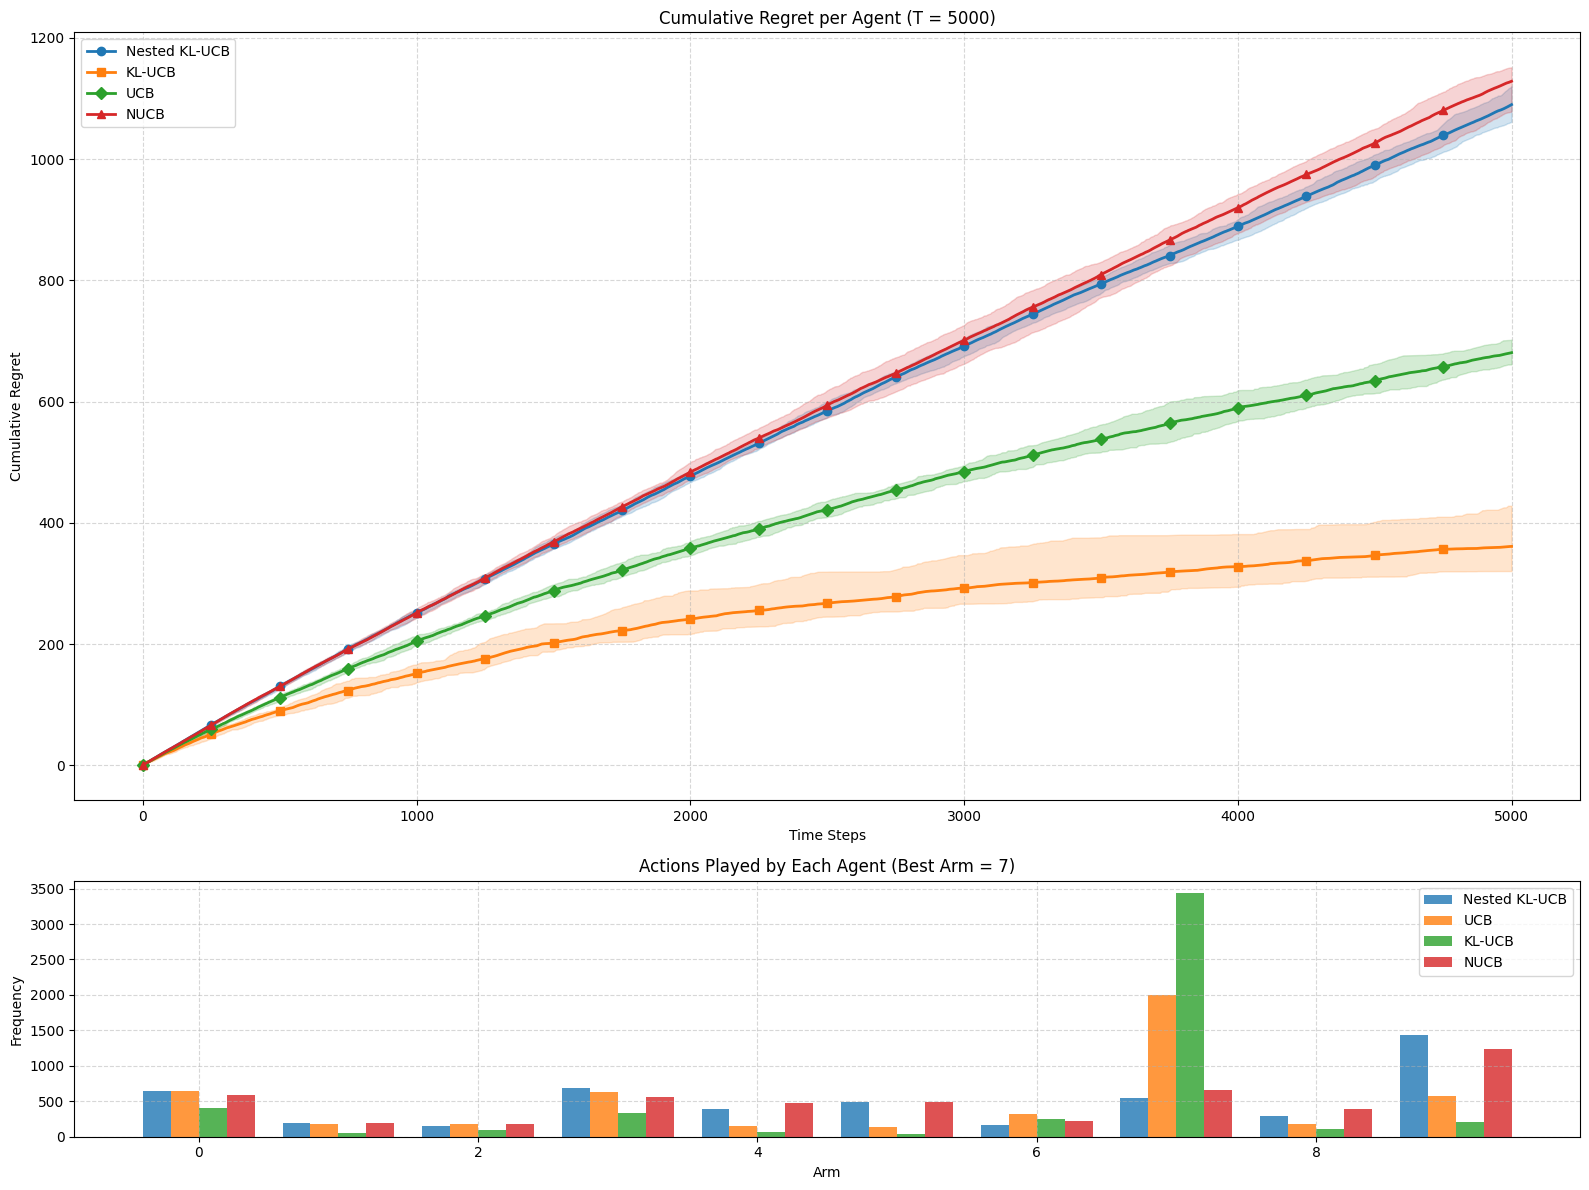

In [19]:
T = 5_000
K = 10

env = NestedBanditEnv()
tree = env.tree
nklucb = NKLUCB(tree, T)
klucb = KLUCB(tree, T)
ucb = UCB(tree, T)
nucb = NUCB(tree, T)
regrets = experiment(environment=env, agents=[nklucb, klucb, ucb, nucb], Nmc=10, T=T)
plot_regret_and_histogram(regrets, agents=[nklucb, ucb, klucb, nucb], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)